In [29]:
import pandas as pd
from collections import defaultdict
import ast
import string
import nltk
import pandas as pd
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Loading the training and the testing datasets into 2 Pnadas dataframes.

In [30]:
train_file = "./validation_data.csv"
test_file = "./train_data.csv"

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

We have used WordNet for lemmatization. We chose it as it enables semantic analysis by understanding word relationships.

In [31]:
# Download NLTK resources
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize words
def lemmatize_text(text):
    try:
        tokens = ast.literal_eval(text)
        
        lemmatized_tokens = [
            (lemmatizer.lemmatize(word), tag)
            for word, tag in tokens
        ]
        
        return str(lemmatized_tokens)  # Convert back to string format
    except Exception as e:
        return text  # Return original if any error occurs

# Function to process text after lemmatization
def process_text(text):
    try:
        tokens = ast.literal_eval(text)  # Convert string representation of list to actual list
        
        processed_tokens = [
            (word if tag in ['PROPN'] else word.lower(), 
             'PUNCT' if word in string.punctuation else tag)  # Assign 'PUNCT' if punctuation
            for word, tag in tokens if tag not in ['_', '.', 'X']  # Remove '_', '.', and 'X' tags
        ]
        
        return str(processed_tokens)  # Convert back to string format
    except Exception as e:
        
        return text

# Identify the column name dynamically
train_col = train_data.columns[0]
test_col = test_data.columns[0]


# Step 1: Apply text processing
train_data[train_col] = train_data[train_col].apply(process_text)
test_data[test_col] = test_data[test_col].apply(process_text)

# Step 2: Lemmatize
train_data[train_col] = train_data[train_col].apply(lemmatize_text)
test_data[test_col] = test_data[test_col].apply(lemmatize_text)

train_data.head(), test_data.head()

[nltk_data] Downloading package wordnet to C:\Users\Valmik
[nltk_data]     Belgaonkar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(                                   [('DF', 'PROPN')]
 0  [('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('pm...
 1  [('the', 'DET'), ('industry', 'NOUN'), ('ha', ...
 2  [('love', 'VERB'), ('this', 'DET'), ('place', ...
 3  [('this', 'DET'), ('problem', 'NOUN'), ('of', ...
 4  [('Esso', 'PROPN'), ('said', 'VERB'), ('the', ...,
                                    [('DF', 'PROPN')]
 0  [('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('pm...
 1  [('the', 'DET'), ('industry', 'NOUN'), ('ha', ...
 2  [('love', 'VERB'), ('this', 'DET'), ('place', ...
 3  [('this', 'DET'), ('problem', 'NOUN'), ('of', ...
 4  [('Esso', 'PROPN'), ('said', 'VERB'), ('the', ...)

We have now made four dictionaries: tag_dict, word_tag_dict, first_word_dict and two_tag_dict. "tag_dict" stores the tag as the key and its frequency as the value. "two_tag_dict" stores the {tag i, tag i + 1} as the key and its frequency as the value. "word_tag_dict" stores the {word, tag} as the key and its frequency as the value. "first_word_dict" stores the first word of each sentence as the key and its frequency as a first word as the value. These dictionaries are used for calculating the Hidden Markov Model parameters.

In [32]:
# Dictionary for tag vs count
tag_dict = defaultdict(int)

# Dictionary for {word, tag} vs count
word_tag_dict = defaultdict(int)

# Dictionary for {tag i, tag i + 1} vs count
two_tag_dict = defaultdict(int)

# Dictionary of first word vs count
first_word_dict = defaultdict(int)

# Total sentence count
sentence_count = 0

for index, row in train_data.iterrows():
    sentence = row.iloc[0]

    if isinstance(sentence, str):
        try:
            sentence = ast.literal_eval(sentence)
        except (ValueError, SyntaxError):
            print(f"Skipping row {index}: Invalid format -> {sentence}")
            continue  # Skip this row

    if not isinstance(sentence, list):
        print(f"Skipping row {index}: Not a list -> {sentence}")
        continue
    
    sentence_count += 1
    
    if len(sentence) > 0:
        first_word_dict[(sentence[0][0], sentence[0][1])] += 1

    prev_tag = None
    for word, tag in sentence:
        tag_dict[tag] += 1
        word_tag_dict[(word, tag)] += 1

        if prev_tag is not None:
            two_tag_dict[(prev_tag, tag)] += 1
        prev_tag = tag

In [33]:
# print(sentence_count)

Now, we have calculated the initial probability vector.

In [34]:
# Initial probability calculation
initial_probability = defaultdict(int)
for key, value in first_word_dict.items():
    initial_probability[key[1]] += value

for key, value in initial_probability.items():
    initial_probability[key] = value/sentence_count

In [35]:
# # Printing initial probability vector
# for key, value in initial_probability.items():
#     print(f"Key = {key}, Value = {value}")

Now, we have calculated the emission probability matrix.

In [36]:
# Emission probability calculation
emission_probability = defaultdict(lambda: defaultdict(int))

for key, value in word_tag_dict.items():
    emission_probability[key[1]][key[0]] = value/tag_dict[key[1]]

In [37]:
# Printing emission probability matrix
# for tag in emission_probability.keys():
#     for word, prob in emission_probability[tag].items():
#         print(f"Tag = {tag}, Word = {word}, Prob = {prob}")

Now we have calculated the transition probability matrix.

In [38]:
# Transition probability calculation
transition_probability = defaultdict(lambda: defaultdict(int))

for key, value in two_tag_dict.items():
    transition_probability[key[0]][key[1]] = value/tag_dict[key[0]]

Now, we have implemented the Viterbi algorithm. We have used .get() to handle missing values in the parameters. If a corresponding dictionary value of a key is missing, we have returned an empty dictionary. If a corresponding float value of a key is missing, we have returned 0.

In [39]:
# Viterbi algorithm

def viterbi_algorithm(sentence:list, unique_tags:list, initial_prob:defaultdict, transition_prob:defaultdict, emission_prob:defaultdict):
    n = len(sentence)
    tags_list = list(unique_tags)  # Convert set to list for indexing

    # Initialize Viterbi and backpointer as a list of dictionaries
    viterbi = [{} for _ in range(n)]
    backpointer = [{} for _ in range(n)]

    # Step 1: Initialization
    for tag in tags_list:
        viterbi[0][tag] = initial_prob.get(tag, 0) * emission_prob.get(tag, {}).get(sentence[0], 0)
        backpointer[0][tag] = None

    # Step 2: Recursion
    for t in range(1, n):  # Iterate over words
        for curr_tag in tags_list:
            max_prob, best_prev_tag = max(
                (viterbi[t - 1].get(prev_tag, 0) * transition_prob.get(prev_tag, {}).get(curr_tag, 0) * emission_prob.get(curr_tag, {}).get(sentence[t], 0), prev_tag)
                for prev_tag in tags_list
            )
            viterbi[t][curr_tag] = max_prob
            backpointer[t][curr_tag] = best_prev_tag

    # Step 3: Termination
    best_tags = []
    best_last_tag = max(tags_list, key=lambda tag: viterbi[-1].get(tag, 0))
    best_tags.append(best_last_tag)

    # Step 4: Backtracking
    for t in range(n - 1, 0, -1):
        best_last_tag = backpointer[t][best_last_tag]
        best_tags.insert(0, best_last_tag)

    return best_tags

The Viterbi algorithm function written above is now used for each sentence in the testing dataset.

In [40]:
predicted_tags = []
actual_tags = []

# Convert string representation of lists into actual lists
validation_sentences = []
for _, row in test_data.iterrows():
    try:
        sentence = ast.literal_eval(row.iloc[0])  # Convert string to list of (word, tag) tuples
        if isinstance(sentence, list) and len(sentence) > 0:
            validation_sentences.append(sentence)
    except (SyntaxError, ValueError):
        continue  # Skip invalid rows

# Check if valid sentences exist
if not validation_sentences:
    print("No valid test sentences found. Please check your dataset.")
    exit()

# Extract list of tags
tags_list = list(tag_dict.keys())

for sentence in validation_sentences:
    words = [word for word, _ in sentence]
    
    if not words:
        continue
    
    actual_tags.extend([tag for _, tag in sentence])
    predicted_tags.extend(
        viterbi_algorithm(
            words,
            tags_list,
            initial_probability,
            transition_probability,
            emission_probability
        )
    )

Now, we have calculated the accuracy of the model.

In [41]:
# Evaluate accuracy
accuracy = accuracy_score(actual_tags, predicted_tags)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 92.02%


For visualization of the result, we have used a confusion matrix. 

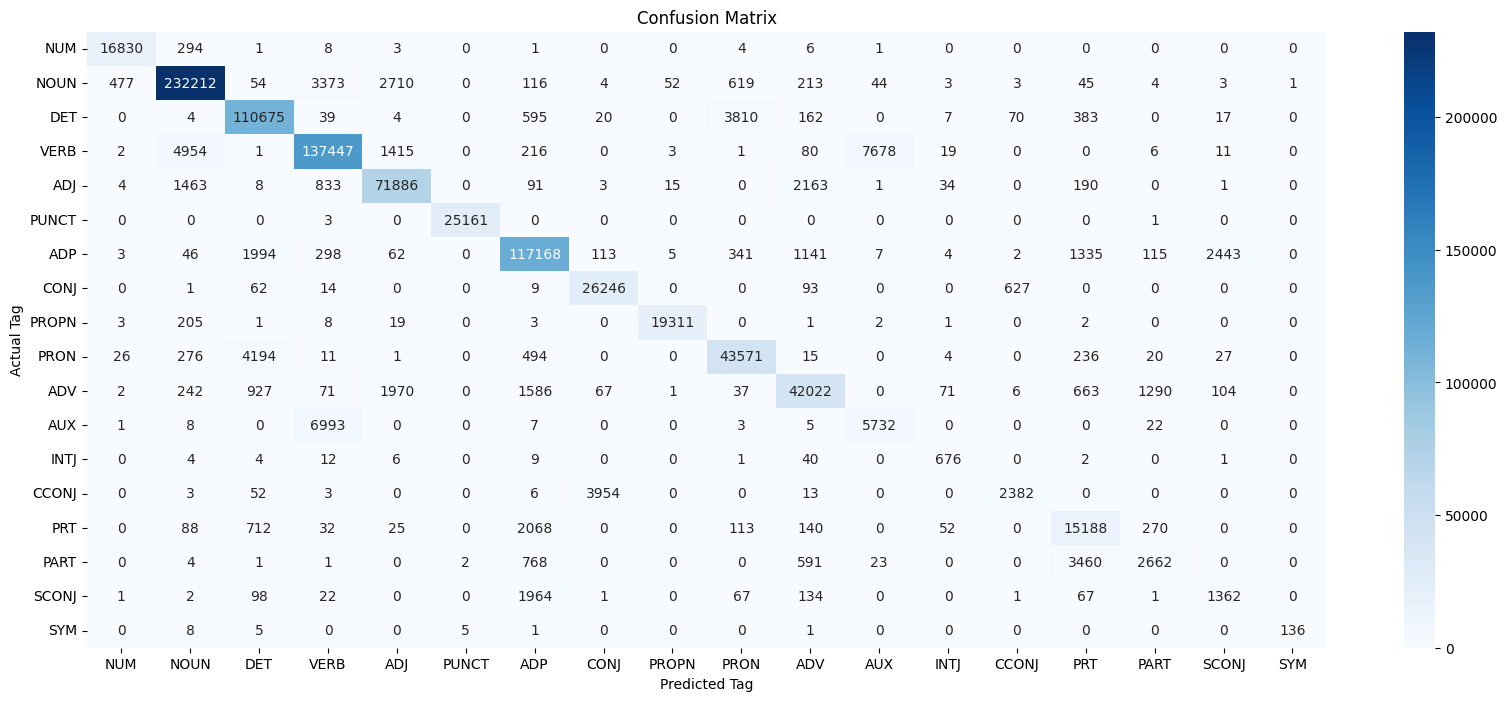

In [42]:
# Get unique tags from tag_dict
unique_tags = list(tag_dict.keys())

cm = confusion_matrix(actual_tags, predicted_tags, labels=list(unique_tags))
plt.figure(figsize=(20, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=unique_tags,
    yticklabels=unique_tags,
    cmap="Blues",
)
plt.xlabel("Predicted Tag")
plt.ylabel("Actual Tag")
plt.title("Confusion Matrix")
plt.show()

Confusion matrix using percentage

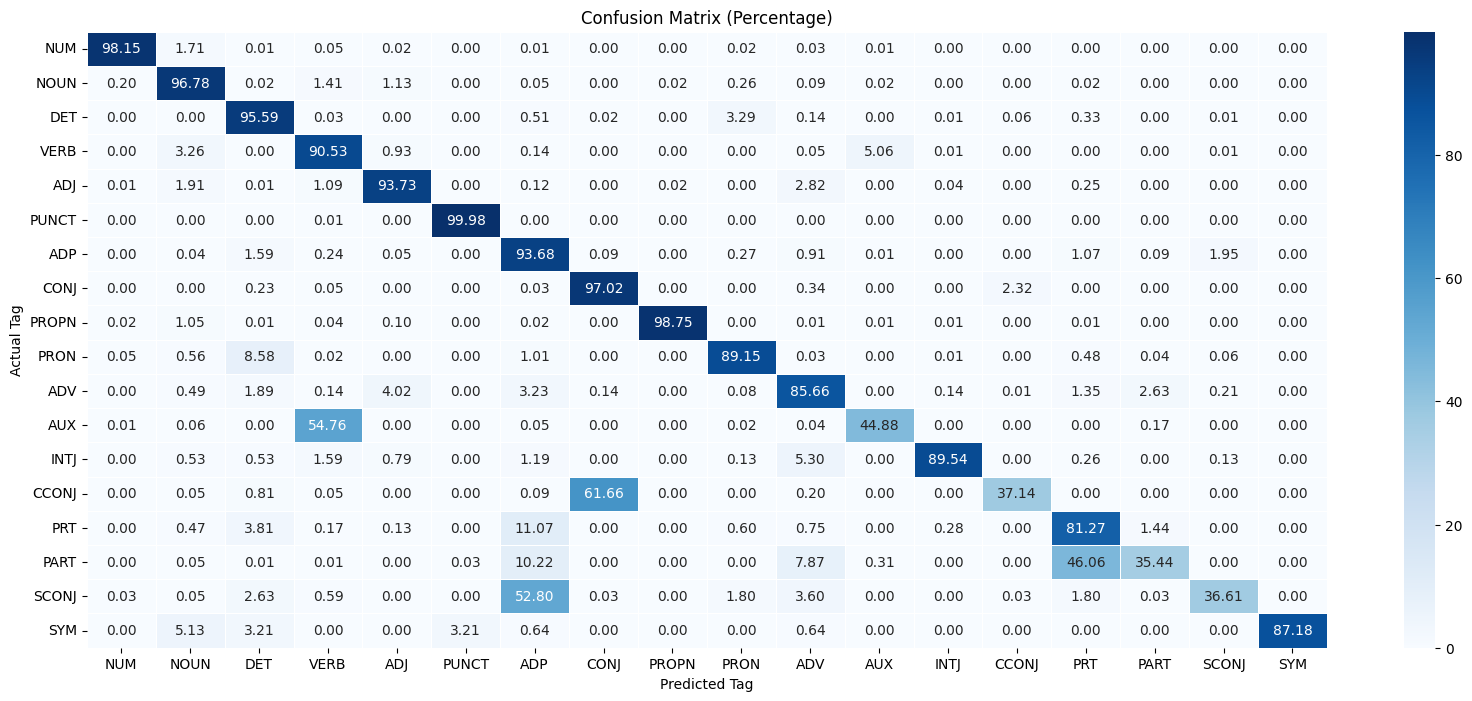

In [43]:
cm = confusion_matrix(actual_tags, predicted_tags, labels=list(tag_dict.keys()))

cm_percentage = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(20, 8))
sns.heatmap(
    cm_percentage,
    annot=True,
    fmt=".2f",
    xticklabels=list(tag_dict.keys()),
    yticklabels=list(tag_dict.keys()),
    cmap="Blues",
    linewidths=0.5,
)
plt.xlabel("Predicted Tag")
plt.ylabel("Actual Tag")
plt.title("Confusion Matrix (Percentage)")
plt.show()